In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Cluster function

In [ ]:
pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.2 MB/s eta 0:00:00


In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

import pandas as pd
from datetime import date, datetime, timedelta
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from itertools import product, combinations, combinations_with_replacement
import seaborn as sns
import geopandas as gpd
from matplotlib import colors
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

import plotly.graph_objs as go
import plotly.express as px
import numpy as np
from collections import defaultdict




## Network Cluster

In [ ]:
def initialize_node_to_comm(adj_matrix):
    return list(range(len(adj_matrix)))
def invert_node_to_comm(node_to_comm):
    communities = defaultdict(set)
    for node, community in enumerate(node_to_comm):
        communities[community].add(node)

    return list(communities.values())


def modularity_martix_NG(adj_matrix, layers, num_nodes, gamma):
    '''
    num_nodes: number of nodes per layer
    '''
    mod_matrix = adj_matrix.copy()
    for i in range(layers):
        adj_matrix_i = mod_matrix[i * num_nodes:i * num_nodes + num_nodes,
                       i * num_nodes:i * num_nodes + num_nodes]
        k_i = np.expand_dims(adj_matrix_i.sum(axis=1), axis=1)
        k_j = k_i.T
        norm = 1 / k_i.sum()
        K = norm * np.matmul(k_i, k_j) * gamma
        mod_matrix[i * num_nodes:i * num_nodes + num_nodes,
        i * num_nodes:i * num_nodes + num_nodes] = adj_matrix_i - K

    return mod_matrix


def modularity_martix_U(adj_matrix, layers, num_nodes, gamma):
    '''
    num_nodes: number of nodes per layer
    '''
    mod_matrix = adj_matrix.copy()
    for i in range(layers):
        adj_matrix_i = mod_matrix[i * num_nodes:i * num_nodes + num_nodes,
                       i * num_nodes:i * num_nodes + num_nodes]
        m2 = adj_matrix_i.sum()
        N = num_nodes
        K = gamma*m2 / (N ** 2)
        mod_matrix[i * num_nodes:i * num_nodes + num_nodes,
        i * num_nodes:i * num_nodes + num_nodes] = adj_matrix_i - K

    return mod_matrix

def S_vector(community, N):
    S = np.zeros((len(community), N))
    i = 0
    for com in community:
        for j in com:
            S[i, j] = 1
        i += 1
    return S


def phase_1(adj_matrix, Q, threshold=0):
    '''
    Input:
    adj_matrix: adjencey matrix
    modularity matrix: Q
    total number of nodes: N
    threshold default set as 0

    Output: S vector
    '''
    if len(Q) < 2:
        print('All nodes merged to 1 community')
        return 'Stop'

    best_community = [{i} for i in range(len(adj_matrix))]
    node = len(adj_matrix)
    S = S_vector(best_community, node)
    M = S.dot(Q).dot(S.T).diagonal().sum()

    label = [i for i in range(len(adj_matrix))]

    gain = 1

    while gain > threshold:
        M_check = M.copy()

        for i, all_nodes in enumerate(adj_matrix):
            print(i)
            neighbors = np.where(all_nodes > 0)[0]
            if len(neighbors) < 2:
                continue
            delta_M = 0
            best_label = label.copy()
            ### store visited community
            visited_community = set()

            inner_old = [k for k, e in enumerate(best_label) if e == best_label[i]]

            for j in neighbors:
                if i == j:
                    continue

                label_t = label.copy()
                if label_t[j] in visited_community:
                    continue
                label_t[i] = label_t[j]
                inner_new = [k for k, e in enumerate(label_t) if e == label_t[i]]
                delta_Q = 2 * (Q[i, inner_new].sum() - Q[i, inner_old].sum())

                if delta_Q > delta_M:
                    #candidate_community = invert_node_to_comm(label_t)
                    best_community = invert_node_to_comm(label_t)
                    delta_M = delta_Q
                    best_label = label_t

                visited_community.add(label_t[j])

            if delta_M <= 0:
                continue

            label = best_label
            S = S_vector(best_community, node)
            M = np.diag(S.dot(Q).dot(S.T)).sum()
        gain = M - M_check
        print('Current modularity:', M)
    return S


def phase_2(adj_matrix, Q, S, true_community):
    updated_Q = S.dot(Q).dot(S.T)

    updated_adj_matrix = S.dot(adj_matrix).dot(S.T)

    new_true_community = []
    for i in S:
        community = set()
        for j in np.where(i > 0)[0]:
            community.update(true_community[j])
        new_true_community.append(community)

    return updated_adj_matrix, updated_Q, new_true_community

#resolution 0.1 -1.5
def multilayer_louvain(adj_matrix, number_of_layers, node_per_layer, resolution, null_network):
    if null_network == 'U':
        Q = modularity_martix_U(adj_matrix, number_of_layers, node_per_layer, resolution)
    if null_network == 'NG':
        Q = modularity_martix_NG(adj_matrix, number_of_layers, node_per_layer, resolution)
    true_community = [{i} for i in range(len(adj_matrix))]
    new_community = [{}]

    while true_community != new_community:
        new_community = true_community
        S = phase_1(adj_matrix, Q, threshold=0)
        if type(S) == str:
            continue
        print('Phase 1 done')
        adj_matrix, Q, true_community = phase_2(adj_matrix, Q, S, new_community)
        print('Phase 2 done')

    return true_community

In [ ]:

'''
df: input timeseries
start_date,end_date: cluster time window
num_layer: number of layer in network
resolution: controls the resolution of the community detection in the Louvain method. A higher value might result in smaller,
             more defined communities, while a lower value could lead to larger, more inclusive communities.
nw: network type
kmin: min number of states in a cluster
option = 0, plot, otherwise return the communities
'''


def network_cluster(df,gd, start_date, end_date, num_layer, resolution, nw,kmin,option):

    df['Week_end'] = pd.to_datetime(df['Week_end'])
    #df1 = df[(df['Week_end'] >= start_date) & (df['Week_end'] <= end_date)]
    df1 = df.copy()
    pivot_df = df1.pivot(index='fips', columns='Week_end', values='rate').fillna(method='ffill').fillna(method='bfill')
    pivot_df = pivot_df.rolling(window=3, axis=1).mean().iloc[:, 3:]
    pivot_df.columns = pd.to_datetime(pivot_df.columns)
    pivot_df = pivot_df.loc[:, (pivot_df.columns >= start_date) & (pivot_df.columns <= end_date)]

    X_normalized = TimeSeriesScalerMeanVariance().fit_transform(pivot_df)
    df_rest_nor = pd.DataFrame(X_normalized.reshape(X_normalized.shape[0], X_normalized.shape[1]))
    df_rest_nor.index = pivot_df.index
    distance_matrix = df_rest_nor.T.corr()
    d_shape = distance_matrix.to_numpy().shape
    all_corr = pd.DataFrame(distance_matrix.to_numpy().reshape(d_shape[0]*d_shape[1]))
    all_corr = all_corr.rename(columns = {0: 'corr'})
    description = all_corr.describe()
    threhd = description.loc['50%', 'corr']
    distance_matrix[distance_matrix<threhd] = 0
    distance_matrix = distance_matrix.fillna(0)
    communities = multilayer_louvain(distance_matrix.to_numpy(), num_layer, d_shape[0], resolution, nw)
    community_df = pd.DataFrame(columns = ['fips'])
    community_df['fips'] = df_rest_nor.index
    for i in range(len(communities)):
        for j in communities[i]:
            if len(communities[i]) > kmin:
                community_df.loc[j, 'label'] = i
            else:
                community_df.loc[j, 'label'] = -1
    community_df = community_df[community_df['label']!= -1].reset_index().drop(columns = ['index'])
    for i in community_df['label'].unique():
        print(i)
        print(len(community_df[community_df['label'] == i]))
    plt.figure(figsize = (10, 8))
    num_clusters = community_df['label'].nunique()
    i = 0
    if option ==0:
      for label in community_df['label'].unique():

          pivot_df[pivot_df.index.isin(community_df[community_df['label'] == label]['fips'].unique())].mean().\
          plot(label = label)
          i += 1
      plt.legend()
      plt.show()
    # Additional mapping and conversion
    gd = gd[gd['location'].str.isnumeric()]
    gd = gd.drop_duplicates(subset=['location'], keep='first')
    gd['location'] = gd['location'].astype(int)
    gd['date'] = pd.to_datetime(gd['date'])
    gd = gd[['location', 'location_name']]
    state_to_label_b = dict(zip(community_df['fips'], community_df['label']))
    gd['label'] = gd['location'].map(state_to_label_b)

    # Mapping state abbreviations
    state_abbreviations = {
        'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
        'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
        'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
        'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
        'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
        'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
        'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
        'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
        'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
        'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
    }
    gd['code'] = gd['location_name'].map(state_abbreviations)

    label_location_dict = gd.groupby('label')['location'].apply(list).to_dict()
    converted_dict = {int(key): [f"{value:02}" for value in values] for key, values in label_location_dict.items()}
    gd1 = gd
    gd1['label_str'] = gd1['label'].astype(str)
    gd1.to_csv(f'/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/clusters/{start_date}_{end_date}_clusters.csv')
    if option ==0:
      fig = px.choropleth(
          gd1,
          locations='code',
          locationmode="USA-states",
          color='label_str',
          scope="usa",
          color_continuous_scale=px.colors.sequential.Plasma,

          title='U.S. States Categorized by Label',
          labels={'label_str': 'Label'}  # Customizing the legend title
      )

      fig.update_layout(
          geo=dict(
              lakecolor='rgb(255, 255, 255)'  # Change lake color if desired
          ),
      )

      fig.show()
    return converted_dict, community_df['label'].value_counts(),gd1

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/smoothedrate.csv')
gd = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/code/target-hospital-admissions.csv')



# Model Function

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch
import pandas as pd
from torch import nn
import torch.nn.functional as F
pd.options.mode.chained_assignment = None
def prepare_data_main_model(df, seq_length, output_size, date_range):
    '''
    df: pandas df contain all the data
    seq_length: number of days consider as input
    output_size: number of days to predict
    date_range: length of history to consider
    Output:
    - full_data: Prepared data as a list of tuples (input_sequence, target_labels).
    - state_ordered: List of unique states in the data.
    '''
    full_data = []
    state_ordered = []

    for state in df.index.get_level_values('fips').unique():
        df_state = df.iloc[df.index.get_level_values('fips') == state]
 # If the length of data is less than or equal to date_range, consider all data
        if len(df_state) <= date_range:
            L = len(df_state.to_numpy())
            train_state = []
            for i in range(L - seq_length - output_size + 1):
                train_seq = df_state.to_numpy()[i:i + seq_length]
                train_label = df_state.to_numpy()[i:i + seq_length + output_size][seq_length:seq_length + output_size,
                              0]
                train_state.append((train_seq, train_label))

            for x in train_state:
                full_data.append(x)
            state_ordered.append(state)
# If data is larger than date_range, consider the most recent date_range data
        else:
            df_state = df.iloc[df.index.get_level_values('fips') == state][-date_range:]

            train_state = []

            L = len(df_state.to_numpy())
            for i in range(L - seq_length - output_size + 1):
                train_seq = df_state.to_numpy()[i:i + seq_length]
                train_label = df_state.to_numpy()[i:i + seq_length + output_size][seq_length:seq_length + output_size,
                              0]
                train_state.append((train_seq, train_label))

            for x in train_state:
                full_data.append(x)
            state_ordered.append(state)
    return full_data, state_ordered

def splitdata(full_data, ratio, batch_size):
    '''
    Split the prepared data into training and testing datasets.

    Parameters:
    - full_data: Prepared data as a list of tuples (input_sequence, target_labels).
    - ratio: Ratio of data to be used for training (e.g., 0.8 for 80% training, 20% testing).
    - batch_size: Size of mini-batches for DataLoader.

    Output:
    - train_loader: DataLoader for the training dataset.
    - test_loader: DataLoader for the testing dataset.
    '''
    train_size = int(ratio * len(full_data))
    test_size = len(full_data) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_data, [train_size, test_size])

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True, drop_last=True)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=True, drop_last=True)

    return train_loader, test_loader


class LSTM(nn.Module):

    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout_rate):
        super().__init__()

        self.input_size = input_size

        self.hidden_layer_size = hidden_layer_size

        self.num_layers = num_layers

        self.output_size = output_size

        self.lstm = nn.LSTM(self.input_size, hidden_layer_size, num_layers, batch_first=True, dropout=dropout_rate)

        self.linear = nn.Linear(hidden_layer_size, 1000)

        self.dropout = nn.Dropout(dropout_rate)

        self.linear2 = nn.Linear(1000, output_size)

    def forward(self, input_seq):
        h = (torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(device),
             torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(device))

        lstm_out, self.hidden_cell = self.lstm(input_seq, h)

        # only return the results for last sequence
        lstm_out = lstm_out[:, -1, :]
        predictions = self.linear(lstm_out)
        #predictions = F.relu(predictions)
        #predictions = F.softplus(predictions)
        predictions = F.leaky_relu(predictions, negative_slope=0.01)
        predictions = self.dropout(predictions)
        predictions = self.linear2(predictions)

        return predictions

 ### Training

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn
from tqdm import trange
from datetime import date, timedelta
from google.colab import output
from collections import OrderedDict
from collections import namedtuple
from itertools import product

import torch.nn.functional as F

def LSTM_train(test_week,region_fips,option,HHS):

    data_file = '/content/drive/MyDrive/Flu Forecasting/code/smoothed_rate_withcovidww.csv'
    if HHS == 1:
      model_file = '/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region model/HHS/'
      prediction_file = '/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/HHS/1000 times/'
      summary_file ='/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/HHS/1000 times/'
    elif HHS == 2:
      model_file = '/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region model/long trend/'
      prediction_file = '/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/long trend/1000 times/'
      summary_file ='/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/long trend/1000 times/'
    else:
      model_file = '/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region model/recent trend (6 weeks)/'
      prediction_file = '/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/recent trend (6 weeks)/1000 times/'
      summary_file ='/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/recent trend (6 weeks)/1000 times/'
    def perdelta(start, end, delta):
        curr = start
        while curr < end:
            yield curr
            curr += delta
    global device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # perform grid search to find a best model
    if option == 0:
      params = OrderedDict(
          target = ['flu_rate'], ### Our target variable
          lr = [0.0001,0.0005],
          batch_size = [2],
          seq_length = [6,8,10], # length of input sequence to predict values
          region = list(region_fips.keys()), # specify the region
          output_size = [4], # we are predicting next four weeks admissions
          num_pred_features = [1],
          week_range = [300], # number of historical data (per state) used to train the model
          input_size = [15], # total number of input features
          hidden_layer_size = [32,64,128], #test
          num_layers = [1], #test
          ratio = [0.8],  # ratio of training set and validation set
          num_epochs = [50],
          dropout_rate = [0.8],
          lossfunc = [nn.SmoothL1Loss(beta=0.05, reduction = 'sum'),

                      ]
      )


      class RunBuilder():
          @staticmethod
          def get_runs(params):

              Run = namedtuple('Run', params.keys())

              runs = []
              for v in product(*params.values()):
                  runs.append(Run(*v))

              return runs

      pd.options.mode.chained_assignment = None

      runs = RunBuilder.get_runs(params)
#directly run the best model
    elif option == 1:


      constant_params = {
          'target': 'flu_rate',  # and other parameters that you don't want to vary

          'batch_size': 2,
          'input_size': 11, # total number of features
          'output_size': 4, # number of weeks to predict
          'num_pred_features': 1,
          'ratio': 0.8,
          'num_epochs':50,
          'dropout_rate': 0.8,
          'lossfunc': nn.SmoothL1Loss(beta=0.05, reduction = 'sum')


      }

      # Variable parameters and their specific combinations
      variable_combinations = [
          { 'lr': 0.00025,'week_range': 72,'seq_length': 12, 'hidden_layer_size': 64, 'num_layers': 1,'region':0},
          { 'lr': 0.0001,'week_range': 64,'seq_length': 6, 'hidden_layer_size': 128, 'num_layers': 1,'region':1},

      ]
      class RunBuilder():
          @staticmethod
          def get_runs(constant_params, variable_combinations):
              Run = namedtuple('Run', list(constant_params.keys()) + list(variable_combinations[0].keys()))

              runs = []
              for combo in variable_combinations:
                  # Merge the constant and variable parameters
                  params = {**constant_params, **combo}
                  runs.append(Run(**params))

              return runs
      runs = RunBuilder.get_runs(constant_params, variable_combinations)



    # output dict
    columns = [
        'Model',
        'region',
        'lr',
        'batch_size',
        'seq_length',
        #'week_range',
        'hidden_layer_size',
        'num_layers',
        'lossfunc',
        'mae_validation',
        'mae_validation_1w',
        'mae_validation_2w',
        'mae_validation_3w',
        'mae_validation_4w',
        'Target'
    ]
    # output dataframe
    df_summary = pd.DataFrame(columns=columns)


    pd.options.mode.chained_assignment = None



    for run in runs:
        if run.target == 'flu_rate':
            results_file = 'flu_rate'

        validation_predictions = []
        validation_labels = []
        # read data
        df = pd.read_csv(data_file)
        #df = df.rename(columns={'End Date': 'Week_end', 'State': 'fips'})
        df['Week_end'] = pd.to_datetime(df['Week_end'])
        # too many missing values in State'11'
        df =  df[df['fips'] != 11]
        df = df.drop(['PRCP_mean', 'SNOW_mean', 'TMAXDELTA', 'TMINDELTA','s05_value','scontrol_value'], axis=1)
    # select region
        #df = df[['fips','Week_end','difference','rate','smoothed_admission']]
        df['fips'] = df['fips'].astype(str).str.zfill(2)
        df = df[df['fips'].isin(region_fips[run.region])]

        # test set is the week from 2024-01-20
        start_date1 = pd.to_datetime(test_week) - timedelta(weeks=run.seq_length )
        end_date1 = pd.to_datetime(test_week) + timedelta(weeks= 1 )
        df_test = df[(df['Week_end'] > start_date1) & (df['Week_end'] < end_date1)] # Use data after 2023-11-01 as testing set
        df_test = df_test.set_index(['fips', 'Week_end'])
        df_test1 = df_test.copy()
        #choose data before 2024-01-06 as training data and validation data and after 2022-08-01
        df_train = df[(df['Week_end'] < pd.to_datetime(test_week) )& (df['Week_end'] >pd.to_datetime('2022-08-01')) ] # Use data before 11/1 as training set
        #df_train = df[(df['Week_end'] < pd.to_datetime('2023-05-01') )& (df['Week_end'] >pd.to_datetime('2022-08-01')) ]
        df_train = df_train.set_index(['fips', 'Week_end'])

        #rescale the data from 0 to 1, normalization
        first_col = df_train.pop(run.target)
        df_train.insert(0, run.target, first_col)
        first_col_2 = df_test.pop(run.target)
        df_test.insert(0, run.target, first_col_2)

        scaler = MinMaxScaler(feature_range=(0, 1))

        scaler.fit(df_train.iloc[:, 1:])
        train_features_normalized = scaler.transform(df_train.iloc[:, 1:])
        test_feature_normalized = scaler.transform(df_test.iloc[:, 1:])

        scaler_target = MinMaxScaler(feature_range=(0, 1))
        scaler_target.fit(np.asarray(df_train.iloc[:, 0]).reshape(-1, 1))
        train_target_normalized = scaler_target.transform(np.asarray(df_train.iloc[:, 0]).reshape(-1, 1))
        test_target_normalized = scaler_target.transform(np.asarray(df_test.iloc[:, 0]).reshape(-1, 1))

        df_train.iloc[:, 1:] = train_features_normalized
        df_train.iloc[:, 0] = train_target_normalized
        df_test.iloc[:, 1:] = test_feature_normalized
        df_test.iloc[:, 0] = test_target_normalized

        '''
        Training
        '''
        # prepare the training and validation data (sequance format)
        full_data_main, state_ordered = prepare_data_main_model(df_train, run.seq_length,
                                                                run.output_size, run.week_range)

        model_main = LSTM(run.input_size, run.hidden_layer_size, run.num_layers, run.output_size ,
                          run.dropout_rate).to(device)
        # split the training data into training set and validation set
        train_loader_main, test_loader_main = splitdata(full_data_main, run.ratio, run.batch_size)

        loss_function = run.lossfunc
      # add l2 regularization
        optimizer_main = torch.optim.Adam(model_main.parameters(), lr=run.lr,weight_decay=1e-5)

        track_loss_train = []
        track_loss_test = []
        best_loss = 100000
        ###

        best_mae_numerical = None
        mae_numerical_weekly = [None] * 4

        best_mae_numerical_weekly = [None] * 4
        for i in trange(run.num_epochs):
    # Set the model in training mode
            model_main.train()
            epoch_loss_train = 0
    # Iterate over the training data
            for i, (seq, labels) in enumerate(train_loader_main):
                seq, labels = seq.to(device), labels.to(device)
                optimizer_main.zero_grad()
                seq = torch.as_tensor(seq).reshape(-1, run.seq_length, run.input_size)
                # Initialize the hidden state of the LSTM
                model_main.hidden_cell = (torch.zeros(run.num_layers, seq.size()[0], run.hidden_layer_size).to(device),
                              torch.zeros(run.num_layers, seq.size()[0], run.hidden_layer_size).to(device))

                # Forward pass to get predictions
                y_pred = model_main(seq.float())

                # Calculate the loss and perform backpropagation
                single_loss = loss_function(y_pred, torch.as_tensor(labels).float())
                single_loss.backward()
                optimizer_main.step()

                epoch_loss_train += single_loss.item()
            # Track the training loss for this epoch
            track_loss_train.append(epoch_loss_train)

            with torch.no_grad():
              # Set the model in evaluation mode
                model_main.eval()
                epoch_loss_test = 0
                ########
                # Initialize lists to store validation predictions and labels
                validation_predictions = []
                validation_labels = []
                for i, (seq, labels) in enumerate(test_loader_main):
                    seq, labels = seq.to(device), labels.to(device)
                    seq = torch.as_tensor(seq).reshape(-1, run.seq_length, run.input_size)
                    model_main.hidden_cell = (torch.zeros(run.num_layers, seq.size(0), run.hidden_layer_size).to(device),
                                    torch.zeros(run.num_layers, seq.size(0), run.hidden_layer_size).to(device))
                    y_pred = model_main(seq.float())

                    single_loss = loss_function(y_pred, torch.as_tensor(labels).float())
                    epoch_loss_test += single_loss.item()
                    ######
                    # Store predictions and labels for later evaluation
                    validation_predictions.extend(y_pred.cpu().numpy())
                    validation_labels.extend(labels.cpu().numpy())
                track_loss_test.append(epoch_loss_test)
            # Combine validation predictions and labels, and perform inverse scaling to get true value
            validation_predictions = np.concatenate(validation_predictions, axis=0)
            validation_labels = np.concatenate(validation_labels, axis=0)
            validation_predictions = scaler_target.inverse_transform(validation_predictions.reshape(-1, 1)).reshape(-1, 4)
            validation_labels = scaler_target.inverse_transform(validation_labels.reshape(-1, 1)).reshape(-1, 4)

            # Calculate total and weekly MSE and accuracy for validation set
            #mse_numerical = np.mean((validation_predictions - validation_labels)**2)
            mae_numerical = np.mean(np.abs(validation_predictions - validation_labels))
            for week in range(4):
                # Calculate weekly MSE
                #mse_numerical_week = np.mean((validation_predictions[:, week] - validation_labels[:, week])**2)
                #mse_numerical_weekly[week] = mse_numerical_week
                mae_numerical_week = np.mean(np.abs(validation_predictions[:, week] - validation_labels[:, week]))
                mae_numerical_weekly[week] = mae_numerical_week
            if epoch_loss_test  < best_loss:
              # Update the best loss and save the model; perform early stopping
                best_mae_numerical = mae_numerical
                best_mae_numerical_weekly = mae_numerical_weekly

                best_loss = epoch_loss_test
                print('Train Loss: ', epoch_loss_train)
                print('Test Loss: ', epoch_loss_test)
                es = 0
                torch.save(model_main.state_dict(),
                              model_file + run.target +'_' +test_week+'_' +str(run.region)+ '_' +
                              str(run.lr) + '_' + str(run.hidden_layer_size)\
                              + '_' + str(run.seq_length) + '_' + str(run.num_layers)\
                              + '_LSTM_weights.pt')
            else:
                es += 1
                print("Counter {} of 5".format(es))
                print('Train Loss: ', epoch_loss_train)
                print('Test Loss: ', epoch_loss_test)


            if es > 4:
                print("Early stopping with best_loss: ", best_loss, "and test_loss for this epoch: ",
                          epoch_loss_test,
                          "...")

                break

        '''
        Prediction
        '''
        df_output = pd.DataFrame(columns=['fips', 'Week_end', 'Prediction_1w',
                                          'Prediction_2w', 'Prediction_3w',
                                          'Prediction_4w'])
      #test set starts with 2023-11-01
        test_weeks = df_test[df_test.index.get_level_values('Week_end') \
                          >= pd.to_datetime(test_week)].index.get_level_values('Week_end').unique()
        test_states = df_test.index.get_level_values('fips').unique()

        m_state_dict_main = torch.load(model_file + run.target+'_' +test_week+ '_' +str(run.region)+ '_' +
                                      str(run.lr) + '_' + str(run.hidden_layer_size) \
                                      + '_' + str(run.seq_length) + '_' + str(run.num_layers) \
                                      + '_LSTM_weights.pt')

        model_main = LSTM(run.input_size, run.hidden_layer_size, run.num_layers,
                          run.output_size, run.dropout_rate).to(device)
        model_main.load_state_dict(m_state_dict_main)

        with torch.no_grad():
            #model_main.eval()
            for fips in test_states:
                for week in test_weeks:
                    seq = df_test[(df_test.index.get_level_values('fips') == fips)\
                    & (df_test.index.get_level_values('Week_end') <= week)][-run.seq_length:].to_numpy()

                    seq = torch.tensor(seq).reshape(-1, run.seq_length, run.input_size).to(device)


                    model_main.hidden_cell = (torch.zeros(run.num_layers, seq.size(0), run.hidden_layer_size).to(device),
                                    torch.zeros(run.num_layers, seq.size(0), run.hidden_layer_size).to(device))
                    prediction = model_main(seq.float())

                    prediction = scaler_target.inverse_transform(prediction.cpu().detach().numpy().reshape(-1, 1))
                    # save prediction results
                    dic = {
                        'fips' : fips,
                        'Week_end' : week,
                        'Prediction_1w' : prediction[0].item(),
                        'Prediction_2w' : prediction[1].item(),
                        'Prediction_3w' : prediction[2].item(),
                        'Prediction_4w' : prediction[3].item()

                    }

                    df_output = pd.concat([df_output, pd.DataFrame([dic])], ignore_index=True)


            df_output.to_csv(prediction_file + run.target + '_' +str(run.region)+ '_' +
                                str(run.lr) + '_' + str(run.hidden_layer_size) \
                                + '_' + str(run.seq_length) + '_' + str(run.num_layers) \
                                + '.csv')

            '''
            Evaluation
            '''





            dic_lstm = {
                'Model': 'LSTM',
                'region': run.region,
                'lr': run.lr,
                'batch_size': run.batch_size,
                'seq_length': run.seq_length,
                #'week_range': run.week_range,
                'hidden_layer_size': run.hidden_layer_size,
                'num_layers': run.num_layers,
                'lossfunc': run.lossfunc,

                'mae_validation': best_mae_numerical,

                'mae_validation_1w': best_mae_numerical_weekly[0],
                'mae_validation_2w': best_mae_numerical_weekly[1],
                'mae_validation_3w': best_mae_numerical_weekly[2],
                'mae_validation_4w': best_mae_numerical_weekly[3],

                'Target': run.target
            }

            print('mae_validation:')
            print(dic_lstm['mae_validation'])


            df_summary = pd.concat([df_summary, pd.DataFrame([dic_lstm])], ignore_index=True)

    df_summary.to_csv(summary_file  +test_week+ 'summarytest.csv')
    df_summary = df_summary.sort_values(by='mae_validation', ascending=True)
    output.clear()
    return df_summary,df_output

###Forecasting

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch import nn
from tqdm import trange
from datetime import date, timedelta

from collections import OrderedDict
from collections import namedtuple
from itertools import product

import torch.nn.functional as F


def LSTM_Prediction(test_week,variable_combinations,HHS):
    n_result = pd.DataFrame()
    data_file = '/content/drive/MyDrive/Flu Forecasting/code/smoothed_rate_withcovidww.csv'

    if HHS == 1:
      model_file = '/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region model/HHS/'
      prediction_file = '/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/HHS/1000 times/'
      summary_file ='/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/HHS/1000 times/'
    elif HHS == 2:
      model_file = '/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region model/long trend/'
      prediction_file = '/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/long trend/1000 times/'
      summary_file ='/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/long trend/1000 times/'
    else:
      model_file = '/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region model/recent trend (6 weeks)/'
      prediction_file = '/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/recent trend (6 weeks)/1000 times/'
      summary_file ='/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/recent trend (6 weeks)/1000 times/'
    global device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def perdelta(start, end, delta):
        curr = start
        while curr < end:
            yield curr
            curr += delta
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    constant_params = {
        'target': 'flu_rate',  # and other parameters that you don't want to vary
        'batch_size': 2,
        'input_size': 15, # total number of features
        'output_size': 4, # number of weeks to predict
        'week_range': 300,
        'num_pred_features': 1,
        'ratio': 0.8,
        'num_epochs':50,
        'num_layers': 1,
        'dropout_rate': 0.8,
        'lossfunc': nn.SmoothL1Loss(beta=0.05, reduction = 'sum')


    }


    class RunBuilder():
        @staticmethod
        def get_runs(constant_params, variable_combinations):
            Run = namedtuple('Run', list(constant_params.keys()) + list(variable_combinations[0].keys()))

            runs = []
            for combo in variable_combinations:
                # Merge the constant and variable parameters
                params = {**constant_params, **combo}
                runs.append(Run(**params))

            return runs

    # Generate runs with selected combinations
    runs = RunBuilder.get_runs(constant_params, variable_combinations)

    pd.options.mode.chained_assignment = None
    for run in runs:
        if run.target == 'flu_rate':
            results_file = 'flu_rate'

        validation_predictions = []
        validation_labels = []
        # read data
        df = pd.read_csv(data_file)
        #df = df.rename(columns={'End Date': 'Week_end', 'State': 'fips'})
        df['Week_end'] = pd.to_datetime(df['Week_end'])
        # too many missing values in State'11'
        df =  df[df['fips'] != 11]
        df = df.drop(['PRCP_mean', 'SNOW_mean', 'TMAXDELTA', 'TMINDELTA','s05_value','scontrol_value'], axis=1)
    # select region

        df['fips'] = df['fips'].astype(str).str.zfill(2)
        df = df[df['fips'].isin(region_fips[run.region])]

        # test set is the week from 2024-01-20
        start_date1 = pd.to_datetime(test_week) - timedelta(weeks=run.seq_length )
        end_date1 = pd.to_datetime(test_week) + timedelta(weeks= 1 )
        df_test = df[(df['Week_end'] > start_date1) & (df['Week_end'] < end_date1)] # Use data after 2023-11-01 as testing set
        df_test = df_test.set_index(['fips', 'Week_end'])
        df_test1 = df_test.copy()
        #choose data before 2024-01-06 as training data and validation data and after 2022-08-01
        df_train = df[(df['Week_end'] < pd.to_datetime(test_week) )& (df['Week_end'] >pd.to_datetime('2022-08-01')) ] # Use data before 11/1 as training set

        df_train = df_train.set_index(['fips', 'Week_end'])

        #rescale the data from 0 to 1, normalization
        first_col = df_train.pop(run.target)
        df_train.insert(0, run.target, first_col)
        first_col_2 = df_test.pop(run.target)
        df_test.insert(0, run.target, first_col_2)

        scaler = MinMaxScaler(feature_range=(0, 1))

        scaler.fit(df_train.iloc[:, 1:])
        train_features_normalized = scaler.transform(df_train.iloc[:, 1:])
        test_feature_normalized = scaler.transform(df_test.iloc[:, 1:])

        scaler_target = MinMaxScaler(feature_range=(0, 1))
        scaler_target.fit(np.asarray(df_train.iloc[:, 0]).reshape(-1, 1))
        train_target_normalized = scaler_target.transform(np.asarray(df_train.iloc[:, 0]).reshape(-1, 1))
        test_target_normalized = scaler_target.transform(np.asarray(df_test.iloc[:, 0]).reshape(-1, 1))

        df_train.iloc[:, 1:] = train_features_normalized
        df_train.iloc[:, 0] = train_target_normalized
        df_test.iloc[:, 1:] = test_feature_normalized
        df_test.iloc[:, 0] = test_target_normalized


        for i in range(1000):
          df_output = pd.DataFrame(columns=['fips', 'Week_end', 'Prediction_1w',
                                            'Prediction_2w', 'Prediction_3w',
                                            'Prediction_4w'])
        #test set starts with 2024-01-06
          test_weeks = df_test[df_test.index.get_level_values('Week_end') \
                              >= pd.to_datetime(test_week)].index.get_level_values('Week_end').unique()
          test_states = df_test.index.get_level_values('fips').unique()

          m_state_dict_main = torch.load(model_file + run.target +'_' +test_week+ '_' +str(run.region)+ '_' +
                                          str(run.lr) + '_' + str(run.hidden_layer_size) \
                                          + '_' + str(run.seq_length) + '_' + str(run.num_layers) \
                                          + '_LSTM_weights.pt')

          model_main = LSTM(run.input_size, run.hidden_layer_size, run.num_layers,
                            run.output_size, run.dropout_rate).to(device)
          model_main.load_state_dict(m_state_dict_main)

          with torch.no_grad():
              #model_main.eval()
              for fips in test_states:
                  for week in test_weeks:
                      seq = df_test[(df_test.index.get_level_values('fips') == fips)\
                        & (df_test.index.get_level_values('Week_end') <= week)][-run.seq_length:].to_numpy()

                      seq = torch.tensor(seq).reshape(-1, run.seq_length, run.input_size).to(device)


                      model_main.hidden_cell = (torch.zeros(run.num_layers, seq.size(0), run.hidden_layer_size).to(device),
                                        torch.zeros(run.num_layers, seq.size(0), run.hidden_layer_size).to(device))
                      prediction = model_main(seq.float())

                      prediction = scaler_target.inverse_transform(prediction.cpu().detach().numpy().reshape(-1, 1))
                      # save prediction results
                      dic = {
                          'fips' : fips,
                          'Week_end' : week,
                          'Prediction_1w' : prediction[0].item(),
                          'Prediction_2w' : prediction[1].item(),
                          'Prediction_3w' : prediction[2].item(),
                          'Prediction_4w' : prediction[3].item()

                      }

                      df_output = pd.concat([df_output, pd.DataFrame([dic])], ignore_index=True)


              df_output.to_csv(prediction_file + run.target +'_' +test_week+ '_' +str(run.region)+ '_' +
                                  str(run.lr) + '_' + str(run.hidden_layer_size) \
                                  + '_' + str(run.seq_length) + '_' + str(run.num_layers) \
                                  + '.csv')
              n_result= pd.concat([n_result, df_output], ignore_index=True)



    n_result = n_result.sort_values(by='fips')
    n_result.to_pickle(summary_file + test_week+ '_allresult.pkl')
    return n_result

# cluster states into groups using hospitalization in 2022-2023 flu season

## Cluster by Long Trend

<ipython-input-9-66eff8db5506>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot_df = df1.pivot(index='fips', columns='Week_end', values='rate').fillna(method='ffill').fillna(method='bfill')
<ipython-input-9-66eff8db5506>:19: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  pivot_df = pivot_df.rolling(window=3, axis=1).mean().iloc[:, 3:]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Current modularity: 270.08260339420156
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Current modularity: 308.8454945374502
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Current modularity: 309.908071599205
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Current modularity: 309.908071599205
Phase 1 done
Phase 2 done
0
1
2
3
Current modularity: 309.908071599205
Phase 1 done
Phase 2 done
0.0
8
1.0
22
2.0
19


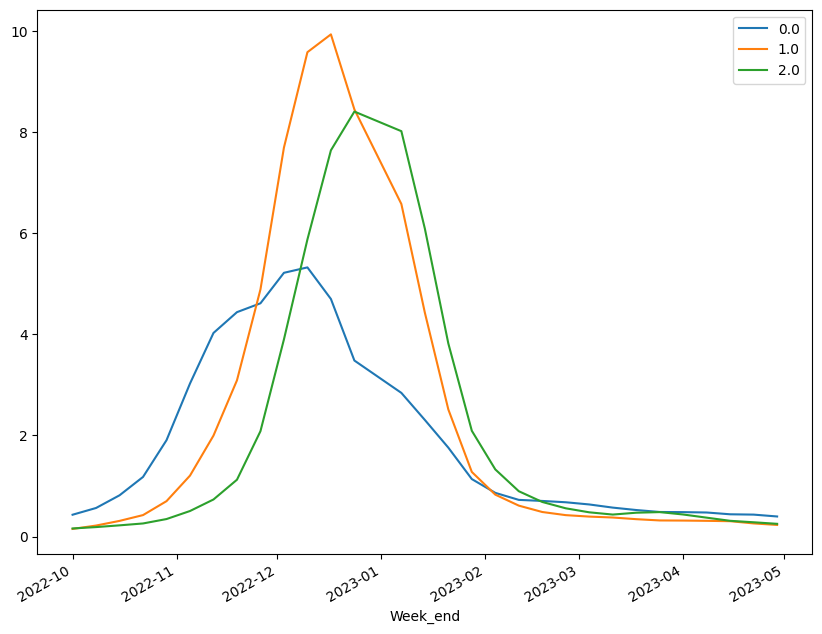

the states are grouped as follow: {0: ['01', '13', '22', '28', '37', '45', '47', '51'], 1: ['02', '05', '04', '06', '09', '10', '17', '18', '20', '21', '24', '27', '29', '34', '35', '32', '39', '41', '48', '53', '54', '56'], 2: ['08', '12', '19', '16', '25', '23', '26', '30', '38', '31', '33', '36', '40', '42', '44', '46', '49', '50', '55']}
number of states in each group: 
 label
1.0    22
2.0    19
0.0     8
Name: count, dtype: int64


In [ ]:
start_date = '2022-10-01'
end_date = '2023-04-30'
num_layer = 1
resolution = 1
nw = 'NG'
kmin = 5

converted_dict_2022, label_counts,gd1 = network_cluster(df,gd,start_date, end_date, num_layer, resolution, nw,kmin,0)
#converted_dict_2022, label_counts,gd1 = flu_forecast_clustering(df,gd,'2022-10-01', '2023-04-30', 2)
print('the states are grouped as follow:',converted_dict_2022)
print('number of states in each group: \n',label_counts)

#Forecasting

##model selection

In [ ]:
from datetime import datetime, timedelta


start_date = datetime.strptime('2023-10-07', '%Y-%m-%d')
end_date = datetime.strptime('2024-02-17', '%Y-%m-%d')
current_date = start_date
dates_list = []

while current_date <= end_date:
    dates_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=7)
dates_list

['2023-10-07',
 '2023-10-14',
 '2023-10-21',
 '2023-10-28',
 '2023-11-04',
 '2023-11-11',
 '2023-11-18',
 '2023-11-25',
 '2023-12-02',
 '2023-12-09',
 '2023-12-16',
 '2023-12-23',
 '2023-12-30',
 '2024-01-06',
 '2024-01-13',
 '2024-01-20',
 '2024-01-27',
 '2024-02-03',
 '2024-02-10',
 '2024-02-17']

###Long Trend/ HHS

In [ ]:
HHS_region_fips = {
    1: ["09", "23", "25", "33", "44", "50"],  # Region 1 - Boston
    2: ["34", "36"],                          # Region 2 - New York
    3: ["10", "24", "42", "51", "54"],  # Region 3 - Philadelphia
    4: ["01", "12", "13", "21", "28", "37", "45", "47"],  # Region 4 - Atlanta
    5: ["17", "18", "26", "27", "39", "55"],  # Region 5 - Chicago
    6: ["05", "22", "35", "40", "48"],        # Region 6 - Dallas
    7: ["19", "20", "29", "31"],              # Region 7 - Kansas City
    8: ["08", "30", "38", "46", "49", "56"],  # Region 8 - Denver
    9: ["04", "06", "15", "32"],              # Region 9 - San Francisco
    10: ["02", "16", "41", "53"]              # Region 10 - Seattle
}

In [ ]:
from datetime import datetime, timedelta
from google.colab import output

start_date = datetime.strptime('2024-01-06', '%Y-%m-%d')
end_date = datetime.strptime('2024-02-17', '%Y-%m-%d')
current_date = start_date
dates_list = []

while current_date <= end_date:
    dates_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=7)
dates_list
test_weeks = dates_list
option = 0
# select HHS or Long Trend
#region_fips = HHS_region_fips
region_fips = converted_dict_2022
for week in test_weeks:
  summarytable,b = LSTM_train(week,region_fips,option,2)



  output.clear()

In [ ]:
df_summary = pd.read_csv('/content/drive/MyDrive/Flu Forecasting/retrainLSTM/result for regions/2023-12-01summarytest.csv')
df_summary = df_summary.sort_values(by='mae_validation', ascending=True)
df_summary

,Unnamed: 0,Model,region,lr,batch_size,seq_length,week_range,hidden_layer_size,num_layers,lossfunc,mae_validation,mae_validation_1w,mae_validation_2w,mae_validation_3w,mae_validation_4w,Target
67,67,LSTM,1,0.00025,2,12,64,64,1,SmoothL1Loss(),0.260815,0.253120,0.298985,0.292843,0.321979,rate
31,31,LSTM,1,0.00010,2,12,64,64,1,SmoothL1Loss(),0.274306,0.291446,0.303669,0.291159,0.273005,rate
32,32,LSTM,1,0.00010,2,12,64,128,1,SmoothL1Loss(),0.276246,0.289739,0.307929,0.249436,0.265093,rate
66,66,LSTM,1,0.00025,2,12,64,32,1,SmoothL1Loss(),0.289750,0.270853,0.297805,0.294056,0.298361,rate
68,68,LSTM,1,0.00025,2,12,64,128,1,SmoothL1Loss(),0.301497,0.282198,0.318220,0.273735,0.284867,rate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,21,LSTM,1,0.00010,2,8,72,32,1,SmoothL1Loss(),0.549830,0.365516,0.462490,0.669409,0.737255,rate
36,36,LSTM,0,0.00025,2,6,64,32,1,SmoothL1Loss(),0.550871,0.334886,0.477829,0.646896,0.749968,rate
10,10,LSTM,1,0.00010,2,6,72,64,1,SmoothL1Loss(),0.558451,0.379861,0.506565,0.636129,0.701096,rate
43,43,LSTM,1,0.00025,2,6,64,64,1,SmoothL1Loss(),0.563133,0.403859,0.526286,0.603663,0.696272,rate


### recent trend

In [ ]:
from datetime import datetime, timedelta
start_date = datetime.strptime('2024-01-13', '%Y-%m-%d')
end_date = datetime.strptime('2024-02-17', '%Y-%m-%d')
current_date = start_date
dates_list = []

while current_date <= end_date:
    dates_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=7)

test_weeks = dates_list

option = 0
for test_week in test_weeks:
  end_date = datetime.strptime(test_week, '%Y-%m-%d')
  start_date = (end_date - timedelta(weeks=6)).strftime('%Y-%m-%d')
  end_date = test_week
  num_layer = 1
  resolution = 1
  nw = 'NG'
  kmin = 5
  converted_dict, label_counts,gd1 = network_cluster(df,gd,start_date, end_date, num_layer, resolution, nw,kmin,1)
  summarytable,b = LSTM_train(test_week,converted_dict,option,3)
  output.clear()

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [ ]:
from google.colab import runtime
runtime.unassign()

##  Forecasting 1000 times

###  Long Trend/HHS

In [ ]:
variable_combinations = []
#summarytable = df_summary
filtered_df_summary = summarytable[summarytable['week_range'] != 32]


for region, group in filtered_df_summary .groupby('region'):

    min_mae_row = group.loc[group['mae_validation'].idxmin()]

    variable_combinations.append({
        'lr': min_mae_row['lr'],
        'seq_length': int(min_mae_row['seq_length']),
        'hidden_layer_size': int(min_mae_row['hidden_layer_size']),
        'region': region  # Including region in the dictionary
    })
variable_combinations

[{'lr': 0.0001,
  'week_range': 64,
  'seq_length': 8,
  'hidden_layer_size': 128,
  'num_layers': 1,
  'region': 0},
 {'lr': 0.0001,
  'week_range': 64,
  'seq_length': 8,
  'hidden_layer_size': 128,
  'num_layers': 1,
  'region': 1},
 {'lr': 0.0001,
  'week_range': 64,
  'seq_length': 8,
  'hidden_layer_size': 128,
  'num_layers': 1,
  'region': 2}]

In [ ]:
start_date = datetime.strptime('2024-01-13', '%Y-%m-%d')
end_date = datetime.strptime('2024-02-17', '%Y-%m-%d')
current_date = start_date
dates_list = []

while current_date <= end_date:
    dates_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=7)

test_weeks = dates_list
region_fips = converted_dict_2022
for test_week in test_weeks:
    print(test_week)
    file_path = f'/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/long trend/1000 times/{test_week}summarytest.csv'
    #file_path = f'/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/HHS/1000 times/{test_week}summarytest.csv'
    df_summary = pd.read_csv(file_path)
    variable_combinations = []
    for region, group in df_summary .groupby('region'):

        min_mae_row = group.loc[group['mae_validation'].idxmin()]

        variable_combinations.append({
            'lr': min_mae_row['lr'],
            'seq_length': int(min_mae_row['seq_length']),
            'hidden_layer_size': int(min_mae_row['hidden_layer_size']),
            'region': region  # Including region in the dictionary
        })
    result = LSTM_Prediction(test_week,variable_combinations,2)
    output.clear()

2024-02-17


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout op

### recent trend

In [ ]:
start_date = datetime.strptime('2023-10-07', '%Y-%m-%d')
end_date = datetime.strptime('2024-02-17', '%Y-%m-%d')
current_date = start_date
dates_list = []

while current_date <= end_date:
    dates_list.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=7)

test_weeks = dates_list
for test_week in test_weeks:
    print(test_week)
    file_path = f'/content/drive/MyDrive/Flu Forecasting/retrainLSTM/region result/recent trend (6 weeks)/1000 times/{test_week}summarytest.csv'
    df_summary = pd.read_csv(file_path)
    variable_combinations = []
    end_date = datetime.strptime(test_week, '%Y-%m-%d')
    start_date = (end_date - timedelta(weeks=6)).strftime('%Y-%m-%d')
    end_date = test_week
    num_layer = 1
    resolution = 1
    nw = 'NG'
    kmin = 5
    region_fips, label_counts,gd1 = network_cluster(df,gd,start_date, end_date, num_layer, resolution, nw,kmin,1)
    for region, group in df_summary .groupby('region'):

        min_mae_row = group.loc[group['mae_validation'].idxmin()]

        variable_combinations.append({
            'lr': min_mae_row['lr'],
            'seq_length': int(min_mae_row['seq_length']),
            'hidden_layer_size': int(min_mae_row['hidden_layer_size']),
            'region': region  # Including region in the dictionary
        })
    result = LSTM_Prediction(test_week,variable_combinations,3)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
'''
variable_combinations = [
    { 'lr': 0.0001,'week_range': 64,'seq_length': 8, 'hidden_layer_size': 128, 'num_layers': 1,'region':0},
    { 'lr': 0.0001,'week_range': 64,'seq_length': 8, 'hidden_layer_size': 128, 'num_layers': 1,'region':1}
]
'''
test_week = '2023-10-01'
#test_week = '2023-11-01'
#test_week = '2023-12-01'
region_fips = converted_dict_2022
#region_fips = HHS_region_fips
result = LSTM_Prediction(test_week,variable_combinations,0)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_lay

In [ ]:
from google.colab import runtime
runtime.unassign()